**Question 2.1**<br> 
In this part, you will build a model to forecast the hourly carpark availability in the future
(aggregated across all carparks instead of looking at each carpark individually). Can you
explain why you may want to forecast the carpark availability in the future? Who would
find this information valuable? What can you do if you have a good forecasting model?


We can find out the potential number of cars on the street at one time as well as the general patterns of people.

This is valuable in particular for governments to plan around things such as erp pricing, road maintainence or upgrading of carparks to increase number of lots to meet the demand.

With a good model, any emergency work to be done can be scheduled for a period where there are lesser cars on the road , or if there needs to be a system wide upgrade for carpark systems.

**Question 2.2**<br>
Build a linear regression model to forecast the hourly carpark availability for a given
month. Use the month of July 2022 as a training dataset and the month of August 2022
as the test dataset. For this part, do not use additional datasets. The target is the hourly
carpark availability percentage and you will have to decide what features you want to
use. Generate two plots: (i) Time series plot of the actual and predicted hourly values
(ii) Scatter plot of actual vs predicted hourly values (along with a line showing how good
the fit is).

In [41]:
import requests
import json
import pandas as pd
from datetime import datetime
from time import sleep
import os
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np
from sklearn import datasets, metrics
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Convert to datetime iso
def toIso(dt):
    return datetime.fromisoformat(dt)

def carparkApiCall(year, month, day, hour, minute, second, error_count):
    def find_local_file(year, month, day, hour, fDir):
        myDir = Path('./data/')
        filePaths = [file for file in myDir.iterdir() if file.name.startswith(f'{year}{month}{day}T{hour.zfill(2)}')]
        is_file_local = False
        for file in filePaths:
            if os.path.isfile(file): #check if file exist
                open(file, 'r')
                fDir = file
                is_file_local = True
                break
        return fDir,is_file_local

    def print_api_error(year, month, day, hour, minute, second, error_count, data):
        print(data)
        print(year,'/', month, '/', day, 'T', hour, minute, second)
        print("error count:", error_count)

    def write_to_file(fDir, data):
        timestamp = data["items"][0]["timestamp"]
        data = data["items"][0]["carpark_data"]
                #create file if response is valid
        os.makedirs(os.path.dirname('./data/'), exist_ok=True)
        with open(fDir, 'w') as fp:
            json.dump(data, fp)
        return data

    def read_from_file(fDir):
        # read from file    
        df = pd.read_json(fDir)
        for heading in ("total_lots","lot_type","lots_available"):
            df[heading] = df["carpark_info"].apply(lambda x: x[0][heading])
        
        # Transform data
        df = df.drop(["carpark_info"], axis=1)
        df['update_datetime'] = df['update_datetime'].apply(toIso)
        df["lots_available"] = df["lots_available"].astype(int)
        df["total_lots"] = df["total_lots"].astype(int)
        return df
    
    max_fail_count = 50
    fDir = f'./data/{year}{month}{day}T{hour.zfill(2)}{minute.zfill(2)}{second.zfill(2)}.json'
    fDir, is_file_local = find_local_file(year, month, day, hour, fDir)
    
    if not is_file_local: # If file doesn't exist, api call
        site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month.zfill(2)}-{day.zfill(2)}T{hour.zfill(2)}%3A{minute.zfill(2)}%3A{second.zfill(2)}'
        response_API = requests.get(site)
        data = response_API.text
        data = json.loads(data)
        
        #check if response is valid
        if response_API.ok and "items" in data and "timestamp" in data["items"][0] and "carpark_data" in data["items"][0]:
            data = write_to_file(fDir, data)
        else:
            error_count+=1
            print_api_error(year, month, day, hour, minute, second, error_count, data)
            if error_count<=max_fail_count:
                return carparkApiCall(year, month, day, hour, minute, second, error_count)
            else:
                f'Api call failed more than {max_fail_count} times :('
            
    df = read_from_file(fDir)
    return df

# Calculate average availability in percentage
def avrAvail(df):
    df["availability_percentage"] = df["lots_available"]/df["total_lots"]
    return df["availability_percentage"].sum()/len(df.index)

**DATA COLLECTION**

features: [day of the week, hour]

label: percentage availability

After testing models with other combination of features such as including day of the month, it was found that models built with this combination of features had the least MSE.

In [42]:
#train set - july

# start date 1 Jul 2022 0001

year = 2022
month = 7
day = 1
hour = 0
minute = 1
second = 0

dt = datetime(year, month, day, hour, minute, second)
dt_interval = timedelta(hours = 1)
total_hrs = 24*30

# day of week,time of day
train_x = []
# avalibility percentage
train_y = []

# generate data
for hr in range(total_hrs):
    dt = dt + dt_interval
    try:
        df = carparkApiCall(str(dt.year), str(dt.month), str(dt.day), str(dt.hour), str(dt.minute), str(dt.second), 0)
        train_x.append([int(dt.weekday()), int(dt.hour)])
        train_y.append(avrAvail(df))
    except:
        print(str(dt.year), str(dt.month), str(dt.day), str(dt.hour), str(dt.minute), str(dt.second))
train_x = np.array(train_x)

In [43]:
#test set - august

# start date 1 Aug 2022 0001

year = 2022
month = 8
day = 1
hour = 0
minute = 1
second = 0

dt = datetime(year, month, day, hour, minute, second)
dt_interval = timedelta(hours = 1)
time_intervals = 24*30

# day of week,time of day
test_x = []
# avalibility percentage
test_y = []

# generate data
for _ in range(time_intervals):
    dt = dt + dt_interval
    try:
        df = carparkApiCall(str(dt.year), str(dt.month), str(dt.day), str(dt.hour), str(dt.minute), str(dt.second), 0)
        test_y.append(avrAvail(df))
        test_x.append([int(dt.weekday()), int(dt.hour)])
    except:
        print(str(dt.year), str(dt.month), str(dt.day), str(dt.hour), str(dt.minute), str(dt.second))
    
    

**Hyper-Parameter Tuning**

Use mean squared error as metric to choose best dimension for polynomial features

0.00035725801078386864 11


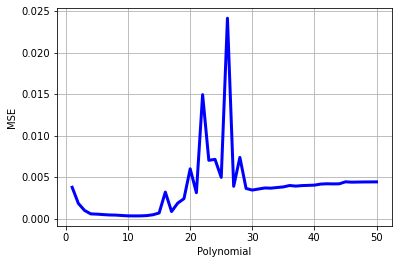

In [44]:
import sklearn.linear_model as lm
from sklearn.preprocessing import PolynomialFeatures
start = 1
dim = start
final_dim = 0
mse_arr = []
mse = 99999999999999999
def linear_regressor(dim):
    poly = PolynomialFeatures(dim)
    train_x_poly = poly.fit_transform(train_x.reshape(-1,2))
    test_x_poly = poly.fit_transform(np.asarray(test_x).reshape(-1,2))
    regressor = lm.LinearRegression()  
    regressor.fit(train_x_poly, train_y) #training the algorithm
    # print(regressor.coef_)
    predicted = regressor.predict(test_x_poly)
    return regressor,mean_squared_error(test_y, predicted)#, mean_absolute_error(train_y, predicted)

while dim<=50:     
    temp_regressor,temp_mse = linear_regressor(dim)
    mse_arr.append(temp_mse)
    if temp_mse<mse:
        regressor = temp_regressor
        final_dim = dim
        mse = temp_mse
    dim += 1
print(mse,final_dim)
plt.plot([x for x in range(start,len(mse_arr)+start)], mse_arr, color="blue", linewidth=3)
plt.grid(True)
plt.xlabel("Polynomial")
plt.ylabel("MSE")
plt.show()


**Build Model**

Model built with the dimension which produces the least mse

0.00035725801078386864


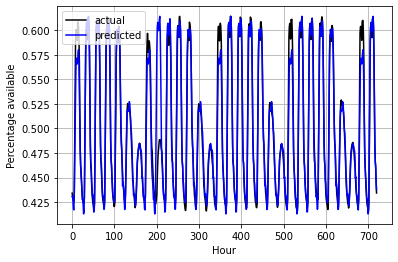

In [45]:
poly = PolynomialFeatures(final_dim)
test_x_poly = poly.fit_transform(np.asarray(test_x).reshape(-1,2))
predicted = regressor.predict(test_x_poly)
print(mean_squared_error(test_y, predicted))
# Plot outputs
plt.plot([x for x in range(len(test_y))], test_y, color="black", label = 'actual')
plt.plot([x for x in range(len(predicted))], predicted, color="blue", label ='predicted')

plt.grid(True)
plt.xlabel("Hour")
plt.ylabel("Percentage available")
plt.legend(loc='upper left')

plt.show()

**Graph of Actual vs Predicted**

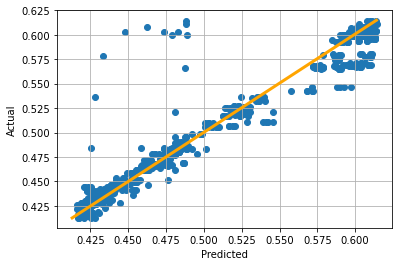

In [46]:
linex = np.linspace(np.min(predicted), np.max(predicted))
m,c = np.polyfit(predicted, test_y, 1)

plt.grid(True)
plt.scatter(test_y, predicted)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.plot(linex, m*linex+c, color="orange", linewidth=3)

plt.show()

**Question 2.3**<br>
Do the same as Question 2.2 above but use support vector regressor (SVR).


In [47]:
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

sc_X = StandardScaler()
sc_y = StandardScaler()
train_x_scaled = sc_X.fit_transform(train_x.reshape(-1, 2))
train_y_scaled = sc_y.fit_transform(np.asarray(train_y).reshape(-1, 1))
test_x_scaled = sc_X.fit_transform(np.array(test_x).reshape(-1,2))
test_y_scaled = sc_y.fit_transform(np.array(test_y).reshape(-1,1))

**Hyper-Parameter Tuning**

Use mean squared error as metric to choose best gamma and c parameter for SVR

In [48]:
start = 1
gamma = start
c = 0
final_c = 0
final_gamma = 0
mse_arr = []
gamma_arr = []
c_arr = []
mse = 99999999999999999
regressor = SVR(kernel='rbf',gamma = 1)

while gamma<20:
    c=0.01
    while c<1:
        temp_regressor = SVR(kernel='rbf',gamma = gamma,C=c)
        temp_regressor.fit(train_x_scaled, train_y_scaled.ravel())
        predicted = temp_regressor.predict(test_x_scaled)
        temp_mse = mean_squared_error(test_y_scaled, predicted)
        c_arr.append(c)
        gamma_arr.append(gamma)
        mse_arr.append(temp_mse)
        if temp_mse < mse:
            mse = temp_mse
            regressor = temp_regressor
            final_gamma = gamma
            final_c = c
        c += 0.01
    gamma += 1


mse: 0.06122647130752073 c: 0.9700000000000006 gamma: 10


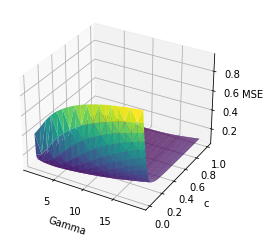

In [49]:
print("mse:",mse,"c:",final_c,"gamma:",final_gamma)
fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
ydata = np.asarray(c_arr)
zdata = np.asarray(mse_arr)
xdata = np.asarray(gamma_arr)
ax.plot_trisurf(xdata, ydata, zdata, edgecolor='none', cmap='viridis')

plt.grid(True)
ax.set_xlabel("Gamma")
ax.set_ylabel("c")
ax.set_zlabel("MSE")
plt.show()

**Build Model**

Model built with the gamma and c parameter which produces the least mse

mse: 0.06122647130752073


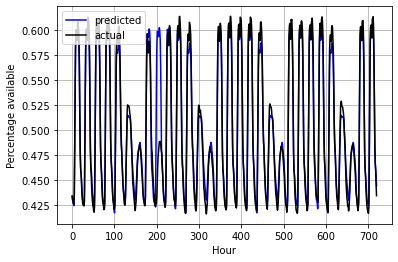

In [50]:
predicted = regressor.predict(test_x_scaled)
print("mse:",mean_squared_error(test_y_scaled, predicted))
predicted = sc_y.inverse_transform(predicted.reshape(-1,1))
plot_y = sc_y.inverse_transform(test_y_scaled)

plt.plot([x for x in range(len(predicted))], predicted, color="blue", label="predicted") # predicted
# plt.plot(x_grid, predicted, color="blue", linewidth=3)
plt.plot([y for y in range(len(plot_y))], plot_y, color="black", label = 'actual') #actual
plt.grid(True)
plt.xlabel("Hour")
plt.ylabel("Percentage available")
plt.legend(loc='upper left')
plt.show()

**Graph of Actual vs Predicted**

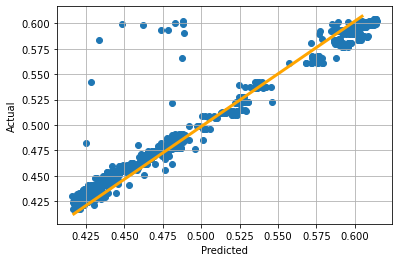

In [51]:
m,c = np.polyfit(predicted.flatten(), plot_y.flatten(), 1)
linex = np.linspace(np.min(predicted), np.max(predicted))

plt.grid(True)
plt.scatter(plot_y, predicted)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.plot(linex, m*linex+c, color="orange", linewidth=3)

plt.show()


**Question 2.4**<br>
Do the same as Question 2.2 above but use decision tree (DT) regressor.

**Hyper-Parameter Tuning**

Use mean squared error as metric to choose best max-depth of decision tree

0.0003254514396925538 8


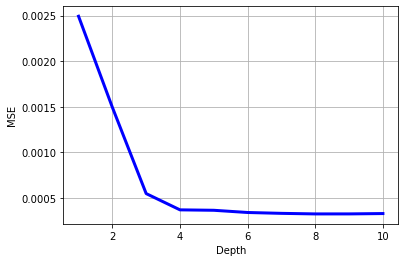

In [52]:

# import the regressor
from sklearn.tree import DecisionTreeRegressor 
  
# create a regressor object
start = 1
depth = start
final_depth = 0
mse_arr = []
mse = 99999999999999999

  
while depth<=10: 
    temp_regressor = DecisionTreeRegressor(max_depth=depth) 
    # fit the regressor with X and Y data
    temp_regressor.fit(train_x.reshape(-1, 2), train_y)
    #5 Predicting a new result
    predicted = temp_regressor.predict(np.asarray(test_x).reshape(-1, 2))
    temp_mse = mean_squared_error(test_y, predicted)
    mse_arr.append(temp_mse)
    if mse > temp_mse:
        mse = temp_mse
        regressor = temp_regressor
        final_depth = depth
    depth += 1

print(mse,final_depth)
plt.plot([x for x in range(start,len(mse_arr)+start)], mse_arr, color="blue", linewidth=3)
plt.grid(True)
plt.xlabel("Depth")
plt.ylabel("MSE")
plt.show()

**Build Model**

Model built with the max-depth parameter which produces the least mse

0.003134237665688061


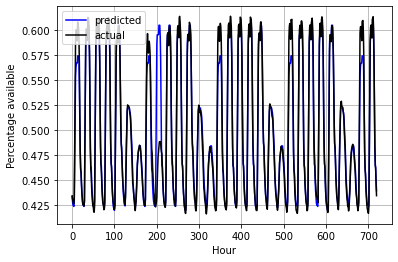

In [53]:
predicted = regressor.predict(np.asarray(test_x).reshape(-1, 2))
print(mean_squared_error(train_y, predicted))

plt.plot([x for x in range(len(predicted))], predicted, color="blue", label = 'predicted') # predicted
# plt.plot(x_grid, predicted, color="blue", linewidth=3)
plt.plot([y for y in range(len(test_y))], test_y, color="black", label ='actual') #actual
plt.grid(True)
plt.xlabel("Hour")
plt.ylabel("Percentage available")
plt.legend(loc='upper left')
plt.show()

**Graph of Actual vs Predicted**

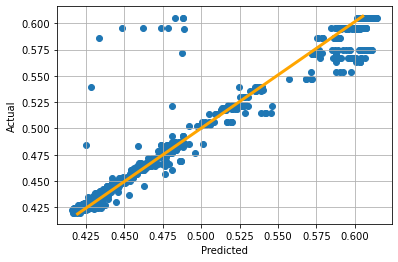

In [54]:
linex = np.linspace(np.min(predicted), np.max(predicted))
m,c = np.polyfit(predicted, test_y, 1)

plt.grid(True)
plt.scatter(test_y, predicted)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.plot(linex, m*linex+c, color="orange", linewidth=3)

plt.show()

**Question 2.5**<br>
Make a final recommendation for the best regression model (out of the 3 methods above)
by choosing a suitable performance metric. To ensure a fair comparison, carry out hyper-parameter tuning for all 3 methods. Then, make a final recommendation selecting only
one model. Include both quantitative and qualitative arguments for your choice.


From the dataset, we can see a general trend which shows:
1. There is a lower percentage of carpark availabile at night
2. There is a lower percentage of carpark available on weekends

These trends could explain human behavioral patterns such as tendency to stay home on weekends, thus leading to cars not being utilized low carpark availabilities

All 3 models were able to detect these trends. This is shown by comparing the plot of actual vs predicted availabilities.

However, there are still flaws and misprediction due to unaccounted variables such as holidays which can cause a deviation from the normal trends.

This flaw is highlighted around the ***200th hour of the test data*** which would be the date, 9 Aug which is the national day in Singapore (public holiday)

After testing models with other combination of features such as including day of the month, it was found that models built with the 2 features (day of the week and hour) as inputs yield the lowest mse.

Therefore all 3 models were standardised to use ***day of week and hour of day as input (features)*** and the ***percentage of availability of all carparks as the output (label)***

The metric use to compare models be it for hyper parameter tuning or for comparison of the 3 models was ***Mean square error (mse)***. This was chosen as we felt that using mse would yeild a better result by penalising edge values. MSE is also a good metric for continous variables and measures the goodness of the fit.

After carrying out hyper parameter tuning to optimize all 3 models, the respective models were found with the following mse:

1. Linear Regession - 0.00035725801078386864
2. SVR - 0.06122647130752073
3. DT - 0.0003254514396925536

It can be seen that the decision tree regressor yielded the ***lowest MSE*** and thus best results. Visually from the graph of actual vs predicted, and the regressor when plotted against time, the plot of the decision tree regressor looks closest to the actual value.

In general, decision tree handles non linearity better than Linear Regression and SVR. From the dataset, we can see that the datapoints are non linear. This makes decision tree generally more suitable.

In addition, the 2 features used in our models are categorical (hour of day and day of week). Decision tree which performs better with ***categorical independent variables*** and ***low number of features*** than linear regression and svm is thus generally a more suitable model.


Hence through quantitative and qualitative reasons, we recommend ***decision tree regressor*** for this case.